In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
from src.plotter import save_fig
import src.plotter as plotter
ROOT_DIR = '.'
IMAGE_DIR = os.path.join(ROOT_DIR, 'images')
DATA_DIR = os.path.join(ROOT_DIR, 'data')
MODEL_DIR = os.path.join(ROOT_DIR, 'models')

- + auto plot maker py
+ making (also a pipeline for dummy variables and autosearch which to keep) - it had effects
- (write function to zip dec tree feature importance)
- add bias or not? how does it changes the model? or leave one dummy out? but that will be the baseline? what if all left in and bias not calculated?
        >>>>> better to leave one dummy out or make an other_dummy (that'll be left out) with all the districts that are uncorroleted (with feature select?!)
creating district averages and only but as dummy for district that have effect on price?!

- 1. **EDA: **
    - corr matrix
    - scatter plot
    - ourlier search
    - geo graph for latitude (color point by price)
- 2.** Modelling**:     
    **cross val check** + a few grid search 
    - **log transform price and size!!!**
    - Linear regression with polynomals + lasso/elastic
    - quick SVM check (del later? +branch)
    - Random Forrest + corssval (and test oob) gridsearch
    - **auto search for feature selection** (in churn rate proj file)
    - XGBoost Regression test!!!!
    - what other algorithm can be used? 
    - try a few neuron nets to get better results

In [3]:
data_path = DATA_DIR + '\\sao-paulo-properties-april-2019.csv'
data = pd.read_csv(data_path)

In [4]:
data.head(2)

Price  Condo  Size  Rooms  Toilets  Suites  Parking  Elevator  Furnished  \
0    930    220    47      2        2       1        1         0          0   
1   1000    148    45      2        2       1        1         0          0   

   Swimming Pool  New               District Negotiation Type Property Type  \
0              0    0  Artur Alvim/São Paulo             rent     apartment   
1              0    0  Artur Alvim/São Paulo             rent     apartment   

    Latitude  Longitude  
0 -23.543138 -46.479486  
1 -23.550239 -46.480718

In [5]:
target = ['Price']
cat_cols = ['District']
drop_cols = ['Negotiation Type', 'Property Type', 'Condo']
dummy_cols = [c for c in data.columns if data[c].nunique() == 2 and c not in drop_cols]
num_cols = [c for c in data.columns if c not in cat_cols + drop_cols + target + dummy_cols]

# Adding logarithmic trasformation
data['Price_log'] = np.log(data['Price'])
data['Size_log'] = np.log(data['Size'])
log_cols = ['Price_log', 'Size_log']

# Creating dummy variables for categorical ones
#data = pd.get_dummies(data,  columns=cat_cols,  drop_first=True)
#cat_dummy_cols = [x for x in data.columns if x.find('District') != -1]
#excl_cat_dummy = [x for x in data.columns if x not in cat_dummy_cols + drop_cols]

sale_data = data[data['Negotiation Type'] == 'sale'].drop(drop_cols, axis=1).copy()
rent_data = data[data['Negotiation Type'] == 'rent'].drop(drop_cols, axis=1).copy()

In [6]:
# Missing values
data.isna().any()

Price               False
Condo               False
Size                False
Rooms               False
Toilets             False
Suites              False
Parking             False
Elevator            False
Furnished           False
Swimming Pool       False
New                 False
District            False
Negotiation Type    False
Property Type       False
Latitude            False
Longitude           False
Price_log           False
Size_log            False
dtype: bool

In [7]:
sale_data.shape, rent_data.shape

((6412, 15), (7228, 15))

# Predicting Sales Price
## Explanatory Data Analysis

In [8]:
from importlib import reload
reload(plotter)

<module 'src.plotter' from 'c:\\CodingFolder\\Projects\\sao_paolo_sale-rent\\src\\plotter.py'>

In [9]:
sale_data.describe().transpose()

count           mean            std           min  \
Price          6412.0  608624.140050  740451.549192  42000.000000   
Size           6412.0      78.611042      50.872359     30.000000   
Rooms          6412.0       2.320805       0.714743      1.000000   
Toilets        6412.0       2.037742       0.917844      1.000000   
Suites         6412.0       0.931535       0.772615      0.000000   
Parking        6412.0       1.326575       0.751658      0.000000   
Elevator       6412.0       0.415471       0.492841      0.000000   
Furnished      6412.0       0.117280       0.321779      0.000000   
Swimming Pool  6412.0       0.539457       0.498480      0.000000   
New            6412.0       0.032283       0.176765      0.000000   
Latitude       6412.0     -22.127513       5.756660    -46.734483   
Longitude      6412.0     -43.705547      11.271783    -49.337815   
Price_log      6412.0      12.982918       0.736555     10.645425   
Size_log       6412.0       4.231659       0.472821      3.401197   

                         25%            50%            75%           max  
Price          250000.000000  380000.000000  679000.000000  1.000000e+07  
Size               50.000000      62.000000      87.000000  6.200000e+02  
Rooms               2.000000       2.000000       3.000000  6.000000e+00  
Toilets             2.000000       2.000000       2.000000  7.000000e+00  
Suites              1.000000       1.000000       1.000000  6.000000e+00  
Parking             1.000000       1.000000       2.000000  7.000000e+00  
Elevator            0.000000       0.000000       1.000000  1.000000e+00  
Furnished           0.000000       0.000000       0.000000  1.000000e+00  
Swimming Pool       0.000000       1.000000       1.000000  1.000000e+00  
New                 0.000000       0.000000       0.000000  1.000000e+00  
Latitude          -23.592848     -23.549693     -23.512534  0.000000e+00  
Longitude         -46.673526     -46.628506     -46.533612  0.000000e+00  
Price_log          12.429216      12.847927      13.428376  1.611810e+01  
Size_log            3.912023       4.127134       4.465908  6.429719e+00

Saving figure Corr Heatmap


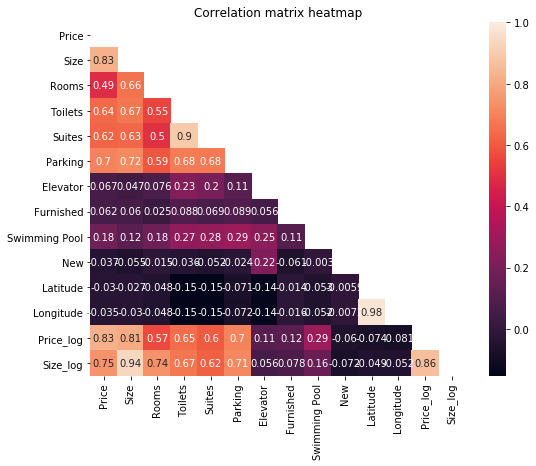

In [10]:
# Correlation heatmap
plotter.corr_heatmap(sale_data, figsize=(8.4, 6.5))
save_fig('Corr Heatmap', verbose = True)
plt.show()

Room, Toilets, Suites, Parking are strongly correlated with the price and with size. These feature might be dropped. Further evaluation needed but probably they don't add that much plus explanatory power besides Size so better to omit them?

## Outlier search

In [11]:
from importlib import reload
reload(plotter)

<module 'src.plotter' from 'c:\\CodingFolder\\Projects\\sao_paolo_sale-rent\\src\\plotter.py'>

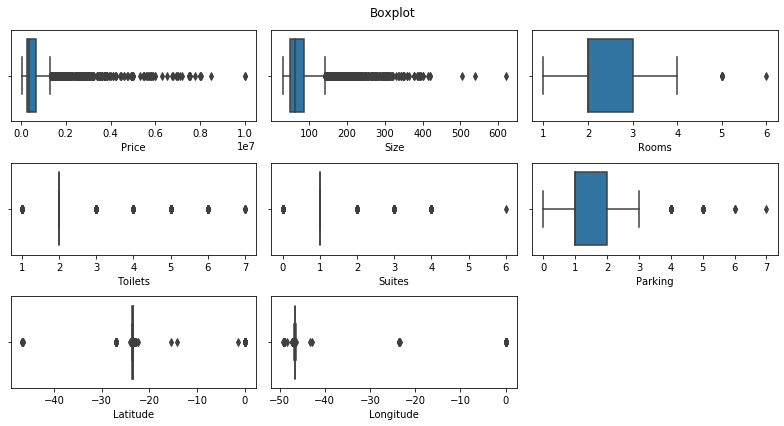

In [12]:
fig, ax =  plotter.boxer(sale_data[target + num_cols], figsize=(11, 6))


Text(0.5, 1.0, 'Geographic position')

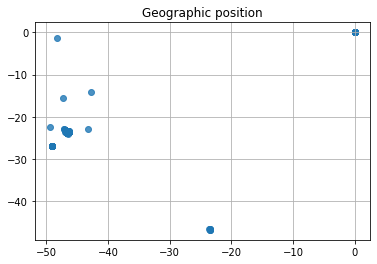

In [13]:
plt.scatter(sale_data.Longitude, sale_data.Latitude, alpha=0.8)
plt.grid(True)
plt.title('Geographic position')

In [14]:
# removing obvious outliners
price_mask = (sale_data.Price < 1.5e6)  # filtering out too expensive apartments
suites_mask = (sale_data.Suites < 6)
lat_mask = (sale_data.Latitude < -23) & (sale_data.Latitude > -23.8)       # filtering out those which not in the city
long_mask = (sale_data.Longitude < -45) & (sale_data.Longitude > -46.9)    # filtering out those which not in the city
df = sale_data[price_mask & suites_mask & lat_mask & long_mask].copy()

Text(0.5, 1.0, 'Geographic position')

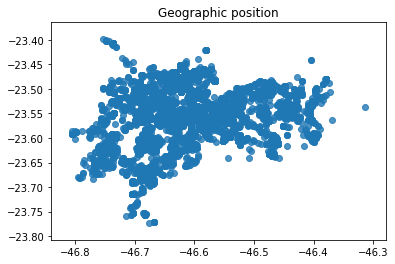

In [15]:
# Checking the location of houses
plt.scatter(df.Longitude, df.Latitude, alpha=0.8 )
plt.title('Geographic position')

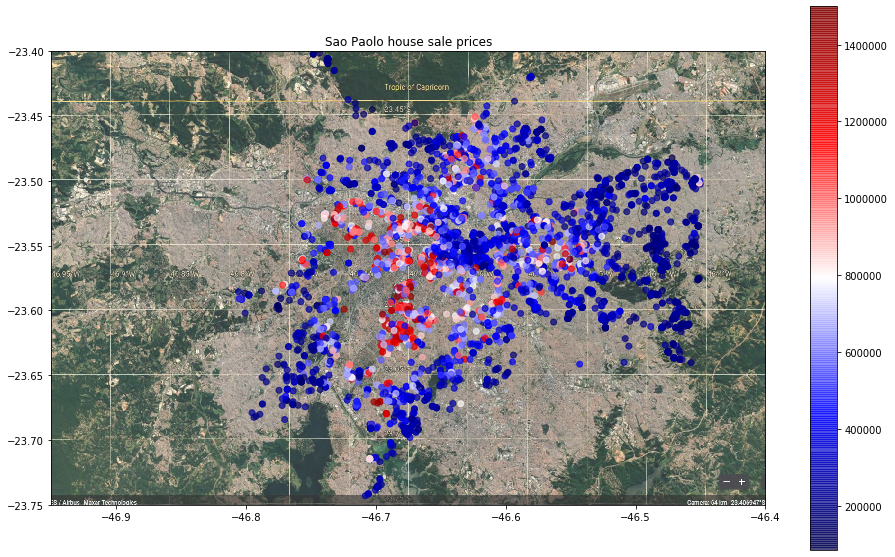

In [16]:
y_max = -23.4
y_min = -23.75
x_max = -46.4
x_min = -46.95 # left

# Trimming a few values to fit on map
df_4map = df[(df.Latitude > y_min) & (df.Latitude < y_max) & (df.Longitude > x_min) &(df.Longitude < x_max -0.05)] 
plt.figure(figsize=(16,10))
img = plt.imread(IMAGE_DIR + "\\sapo_satelite_23-4_46-95.jpg")
plt.imshow(img, alpha=0.8, extent = [x_min, x_max, y_min, y_max] )

plt.scatter(df_4map.Longitude, df_4map.Latitude, alpha=0.7, c=df_4map.Price,  cmap = 'seismic')
title='Sao Paolo house sale prices'
plt.title(title)
plt.colorbar()
save_fig(title)
plt.show()

sns.pairplot(df[target + log_cols + ['Size', 'Longitude', 'Latitude']], 
            kind = 'reg',
            diag_kind = 'kde',
            #diag_kws={'bins': 30, 'color':'green'},
            plot_kws={'line_kws':{'color':'red'},  
                    'scatter_kws': {'alpha': 0.5} })
save_fig('Numeric fields histograms and scatterplots')

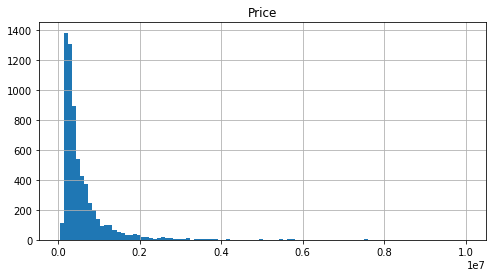

In [17]:
sale_data.hist(column= 'Price',
                bins=100,
                figsize=(8, 4) )
plt.show()

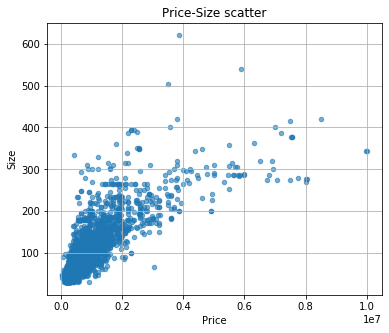

In [18]:
sale_data.plot.scatter('Price','Size',
                        alpha=0.6,
                         grid=True,
                        figsize=(6,5))
plt.title('Price-Size scatter')
plt.show()

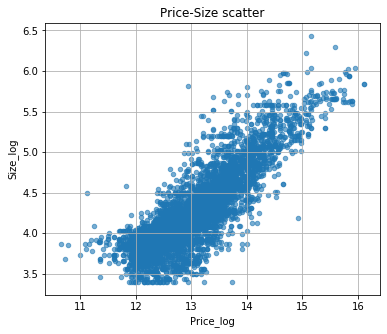

In [19]:
sale_data.plot.scatter('Price_log','Size_log',
                        alpha=0.6,
                         grid=True,
                        figsize=(6,5))
plt.title('Price-Size scatter')
plt.show()

### district avergage price plot

from mpl_toolkits.basemap import Basemap

m = Basemap(urcrnrlat=f.Longitude.max(),     # top
              urcrnrlon=f.Latitude.max(),   # bottom
              llcrnrlat=f.Longitude.min(),     # left
              llcrnrlon=f.Latitude.min(),
                epsg=4326)
#http://server.arcgisonline.com/arcgis/rest/services
#EPSG Number of America is 4269

m.arcgisimage(service='World_Physical_Map', xpixels = 1500, verbose= True)
plt.show()

# Pipelines

In [24]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PolynomialFeatures

In [21]:
sale_data.columns

Index(['Price', 'Size', 'Rooms', 'Toilets', 'Suites', 'Parking', 'Elevator',
       'Furnished', 'Swimming Pool', 'New', 'District', 'Latitude',
       'Longitude', 'Price_log', 'Size_log'],
      dtype='object')

In [22]:
num_cols, dummy_cols, cat_cols

(['Size', 'Rooms', 'Toilets', 'Suites', 'Parking', 'Latitude', 'Longitude'],
 ['Elevator', 'Furnished', 'Swimming Pool', 'New'],
 ['District'])

In [25]:
# Pipelines
cat_encoder = OneHotEncoder(drop = 'first', sparse = False)
poly = PolynomialFeatures(degree=2, include_bias=False) 

orig_pipeline =  ColumnTransformer([
        ("num", 'passthrough', num_cols),
        ("dummy", 'passthrough', dummy_cols),
        ("cat", cat_encoder, cat_cols),
        ])

# Modelling

In [28]:
from sklearn.model_selection import train_test_split
import src.evaluation as ev
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor

In [26]:
def split_data(pipeline, data, target, test_size=0.2):
    '''Returning X_train, X_test, y_train, y_test'''
    train_set, test_set = train_test_split(sale_data, test_size= test_size, random_state = 64)

    X_train = pipeline.fit_transform( train_set )
    y_train = train_set[target].values
    X_test = pipeline.fit_transform( test_set )
    y_test = test_set[target].values

    return X_train, X_test, y_train, y_test

def run_model_evaluation(model, X_train, y_train):
    scores = ev.get_cros_val_scores(model, X_train, y_train)
    return ev.mean_scores_format(scores)

In [29]:
# Testing propuses
from importlib import reload
reload(ev)

<module 'src.evaluation' from 'c:\\CodingFolder\\Projects\\sao_paolo_sale-rent\\src\\evaluation.py'>

## Linear regression

In [30]:
lin_reg = LinearRegression()

print('Simple Linear regression')
X_train, X_test, y_train, y_test = split_data(orig_pipeline, sale_data, target)
run_model_evaluation(lin_reg, X_train, y_train)

Simple Linear regression


## With polynomal features

In [31]:
poly_pipe = ColumnTransformer([
        ("num", poly, num_cols), 
        ("dummy", 'passthrough', dummy_cols),
        ("cat", cat_encoder, cat_cols),
        ])

In [32]:
print('Linear regression with polynomal features')
print('Cross validation scores:')
X_train, X_test, y_train, y_test = split_data(poly_pipe, sale_data, target)
run_model_evaluation(lin_reg, X_train, y_train)

Linear regression with polynomal features
Cross validation scores:


## Regression with logarithmic *Price* adnd *Size*

In [33]:
log_size_pipe = ColumnTransformer([
        ("num", poly, ['Size_log'] + num_cols[1:] ),
        ("dummy", 'passthrough', dummy_cols),
        ("cat", cat_encoder, cat_cols),
        ])

In [34]:
print('Linear regression with polynomal features')
print('Cross validation scores:')
X_train, X_test, y_train, y_test = split_data(log_size_pipe, sale_data, 'Price_log')
run_model_evaluation(lin_reg, X_train, y_train)

Linear regression with polynomal features
Cross validation scores:


In [35]:
print('Evaluation on full train set with exp trasformation')
ev.model_scores(lin_reg, X_train, y_train, exp=True )

Evaluation on full train set with exp trasformation


MAE        RMSE     R2
scores  102828.497  240967.248  0.898

**Polynomal regression models overfitting so let's use seme regularization:**
## Lasso model

In [206]:
print('Lasso regularization with polynomal features')
print('Cross validation scores:')
lasso = Lasso(alpha=0.05, normalize=False)
X_train, X_test, y_train, y_test = split_data(log_size_pipe, sale_data, 'Price_log')
run_model_evaluation(lasso, X_train, y_train)

Lasso regularization with polynomal features
Cross validation scores:


In [70]:
ev.model_scores(lasso, X_train, y_train, exp=True )

MAE        RMSE     R2
scores  173906.626  399696.295  0.718

### Gridsearch on Lasso

In [143]:
np.arange(1,1000,100)/100000

array([1.00e-05, 1.01e-03, 2.01e-03, 3.01e-03, 4.01e-03, 5.01e-03,
       6.01e-03, 7.01e-03, 8.01e-03, 9.01e-03])

In [148]:
param_grid = [
    {'alpha' : [4e-06, 3e-06, 2e-06, 1e-06, 5e-05, 9e-05, 8e-05, 7e-05 ] } ]
grid_search = GridSearchCV(lasso, param_grid, cv=10,
                           scoring='r2',
                           return_train_score=True)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=Lasso(alpha=0.05, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=False, positive=False,
                             precompute=False, random_state=None,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'alpha': [4e-06, 3e-06, 2e-06, 1e-06, 5e-05, 9e-05,
                                    8e-05, 7e-05]}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='r2', verbose=0)

In [149]:
pd.DataFrame(grid_search.cv_results_).sort_values('mean_test_score')

mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha  \
5       0.957104      0.106138         0.000798        0.001165       9e-05   
6       0.900134      0.035730         0.000848        0.001199       8e-05   
7       0.887654      0.045969         0.001277        0.001544       7e-05   
4       1.006469      0.115160         0.000568        0.000759       5e-05   
0       0.982754      0.106015         0.001033        0.001463       4e-06   
1       0.903645      0.038574         0.001621        0.001670       3e-06   
2       0.912579      0.086768         0.000618        0.000967       2e-06   
3       1.025842      0.155223         0.001299        0.001291       1e-06   

             params  split0_test_score  split1_test_score  split2_test_score  \
5  {'alpha': 9e-05}           0.899504           0.928500           0.907894   
6  {'alpha': 8e-05}           0.899978           0.929268           0.908418   
7  {'alpha': 7e-05}           0.900513           0.930011           0.909059   
4  {'alpha': 5e-05}           0.901238           0.931367           0.910169   
0  {'alpha': 4e-06}           0.902714           0.933684           0.911030   
1  {'alpha': 3e-06}           0.902731           0.933705           0.911002   
2  {'alpha': 2e-06}           0.902746           0.933724           0.910972   
3  {'alpha': 1e-06}           0.902760           0.933742           0.910938   

   split3_test_score  ...  split2_train_score  split3_train_score  \
5           0.909023  ...            0.919790            0.918823   
6           0.909694  ...            0.920299            0.919426   
7           0.910314  ...            0.920877            0.920001   
4           0.911451  ...            0.921985            0.921095   
0           0.912892  ...            0.923553            0.922632   
1           0.912893  ...            0.923561            0.922639   
2           0.912892  ...            0.923566            0.922645   
3           0.912888  ...            0.923569            0.922649   

   split4_train_score  split5_train_score  split6_train_score  \
5            0.919800            0.919404            0.918908   
6            0.920165            0.920036            0.919411   
7            0.920738            0.920460            0.919929   
4            0.921718            0.921632            0.920877   
0            0.923254            0.923218            0.922471   
1            0.923262            0.923225            0.922478   
2            0.923267            0.923231            0.922484   
3            0.923271            0.923235            0.922488   

   split7_train_score  split8_train_score  split9_train_score  \
5            0.919559            0.918929            0.917396   
6            0.920194            0.919353            0.918057   
7            0.920668            0.920024            0.918620   
4            0.921749            0.920881            0.919627   
0            0.923247            0.922461            0.921204   
1            0.923254            0.922468            0.921212   
2            0.923259            0.922474            0.921218   
3            0.923262            0.922478            0.921222   

   mean_train_score  std_train_score  
5          0.919003         0.001031  
6          0.919554         0.000994  
7          0.920101         0.000997  
4          0.921129         0.001012  
0          0.922686         0.000975  
1          0.922693         0.000975  
2          0.922699         0.000974  
3          0.922703         0.000974  

[8 rows x 31 columns]

In [ ]:
lasso_best = grid_search.best_estimator_

In [152]:
run_model_evaluation(lasso_best, X_train, y_train)

In [154]:
ev.model_scores(lasso_best, X_train, y_train, exp=True )

MAE        RMSE     R2
scores  103286.488  241182.756  0.897

In [155]:
ev.model_scores(lasso_best, X_test, y_test, exp=True )

MAE        RMSE    R2
scores  97226.146  206296.315  0.91

In [207]:
lasso_best.fit(X_train, y_train)
y_pred = lasso_best.predict(X_train)
plt.plot(np.exp(y_pred), np.exp(y_train), 'o')

## Graph y_act and y_pred!!

## Random Forrest

In [199]:
from sklearn.ensemble import RandomForestRegressor
rforrest = RandomForestRegressor(n_estimators= 200,
                                criterion='mse', 
                                max_depth=10, 
                                max_leaf_nodes=42,
                                max_features='auto', 
                                min_samples_leaf=4,
                                n_jobs= -1)

In [200]:
X_train, X_test, y_train, y_test = split_data(orig_pipeline, sale_data, 'Price')
run_model_evaluation(rforrest, X_train, y_train)

In [167]:
rforrest = RandomForestRegressor(criterion='mse')
param_grid = [
    {'n_estimators' : [10] ,
     'max_depth': [5, 10, 15], 
     'min_samples_leaf': [2,3,4,5], 
     'max_leaf_nodes': [40, 50, 100, 120, 150, 200]} ]
grid_search = GridSearchCV(rforrest, param_grid, cv=10,
                           scoring='r2',
                           return_train_score=True)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_j

In [ ]:
pd.DataFrame(grid_search.cv_results_).sort_values('mean_test_score')[['params', 'mean_test_score', 'mean_train_score']]

In [169]:
grid_search.best_params_

{'max_depth': 10,
 'max_leaf_nodes': 150,
 'min_samples_leaf': 2,
 'n_estimators': 10}

---------------------------
OLD TRYs

In [160]:
#sale_df_max = sale_data[ sale_data.Price < 400000 ]
y = sale_data[target]
X = sale_data.drop(target + log_cols, axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state = 64)

In [215]:
lin_reg = LinearRegression()

scores = ev.get_cros_val_scores(lin_reg, X_train, y_train)
np.round(scores.mean(),3).unstack().style.format('{0:,}')

In [216]:
ev.mean_scores_format(scores)

In [110]:
y = sale_data['Price_log']
X = sale_data.drop(['Size', 'Price', 'Price_log'] , axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state = 64)

In [111]:
lin_reg = LinearRegression()

scores = ev.get_cros_val_scores(lin_reg, X_train, y_train)
np.round(scores.mean(),3).unstack().abs()

score  neg_mean_absolute_error  neg_root_mean_squared_error     r2
set                                                               
test                     0.255                        0.335  0.793
train                    0.254                        0.334  0.796

In [ ]:
model.fit(X,y)
y_pred = model.predict(X)

In [139]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2

In [148]:
def get_scores(model, X, y, exp=False):
    model.fit(X,y)
    y_pred = model.predict(X)
    if exp:
        y = np.exp(y) 
        y_pred = np.exp(y_pred)
    scores = ev.get_metrics(y, y_pred)
    return scores

In [149]:
get_scores(lin_reg, X_train, y_train)

{'MAE': 0.25449374676454434,
 'RMSE': 0.1116018978128446,
 'R2': 0.7957650088466117}

In [153]:
get_scores(lin_reg, X_train, y_train, exp =True)

{'MAE': 172689.82706844708,
 'RMSE': 383540.3042869182,
 'R2': 0.7403935019077914}

In [156]:
get_scores(lin_reg, X_test, y_test, exp =True)

{'MAE': 161725.4236881652, 'RMSE': 336479.7135336361, 'R2': 0.7611000102185831}

In [28]:
sale_data.columns

Index(['Price', 'Size', 'Rooms', 'Toilets', 'Suites', 'Parking', 'Elevator',
       'Furnished', 'Swimming Pool', 'New', 'Latitude', 'Longitude'],
      dtype='object')

In [29]:
#sale_df_max = sale_data[ sale_data.Price < 400000 ]
y = sale_data[target]
X = sale_data.drop(target + ['Rooms', 'Toilets', 'Suites', 'Parking'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state = 64)

lin_reg = LinearRegression()

scores = ev.get_cros_val_scores(lin_reg, X_train, y_train)
np.round(scores.mean(),3).unstack().style.format('{0:,}')

In [24]:
lin_reg = LinearRegression(fit_intercept=False)

scores = ev.get_cros_val_scores(lin_reg, X_train, y_train)
np.round(scores.mean(),3).unstack().style.format('{0:,}')

In [25]:
s = scores_mean(scores)
s['neg_mean_absolute_error'].apply(lambda x: -1*x if x < 0 else x)

set
test     198552.444
train    197732.431
Name: neg_mean_absolute_error, dtype: float64

In [26]:
lin_reg = LinearRegression()
run_n_evaluate_model(X_train, y_train, lin_reg)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
Test avg cros_val scores:
MAE: 195685.77 
MSE: 394936.435
R2 score: 0.721
---------------
Train avg cros_val scores::
MAE: 194756.093 
RMSE: 393632.592
R2 score: 0.727


In [27]:
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train)

In [28]:
run_n_evaluate_model(X_train_poly, y_train, lin_reg)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
Test avg cros_val scores:
MAE: 179188.832 
MSE: 472157.374
R2 score: 0.456
---------------
Train avg cros_val scores::
MAE: 164099.311 
RMSE: 343680.099
R2 score: 0.791


In [49]:
lasso = Lasso(alpha=10, normalize=True)
run_n_evaluate_model(X_train_poly, y_train, lasso)

Lasso(alpha=10, copy_X=True, fit_intercept=True, max_iter=1000, normalize=True,
      positive=False, precompute=False, random_state=None, selection='cyclic',
      tol=0.0001, warm_start=False)
Test avg cros_val scores:
MAE: 170384.91 
MSE: 368241.647
R2 score: 0.756
---------------
Train avg cros_val scores::
MAE: 165762.257 
RMSE: 347494.517
R2 score: 0.787


In [47]:
# Without Rooms!
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly_noroom = poly.fit_transform(X_train.drop('Rooms', axis=1) )
lasso = Lasso(alpha=10, normalize=True)
run_n_evaluate_model(X_train_poly_noroom, y_train, lasso)

Lasso(alpha=10, copy_X=True, fit_intercept=True, max_iter=1000, normalize=True,
      positive=False, precompute=False, random_state=None, selection='cyclic',
      tol=0.0001, warm_start=False)
Test avg cros_val scores:
MAE: 177068.09 
MSE: 372990.502
R2 score: 0.749
---------------
Train avg cros_val scores::
MAE: 172756.025 
RMSE: 353831.587
R2 score: 0.779


In [48]:
forrest = DecisionTreeRegressor(max_depth=10, max_leaf_nodes=35)
run_n_evaluate_model(X_train, y_train, forrest)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=10,
                      max_features=None, max_leaf_nodes=35,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')
Test avg cros_val scores:
MAE: 156147.785 
MSE: 302217.283
R2 score: 0.83
---------------
Train avg cros_val scores::
MAE: 138915.369 
RMSE: 228639.84
R2 score: 0.908


In [31]:
from sklearn.linear_model import ElasticNet
elastic = ElasticNet(alpha=0.0001, l1_ratio= 0.9, normalize=True)
run_n_evaluate_model(X_train_poly, y_train, elastic)

ElasticNet(alpha=0.0001, copy_X=True, fit_intercept=True, l1_ratio=0.9,
           max_iter=1000, normalize=True, positive=False, precompute=False,
           random_state=None, selection='cyclic', tol=0.0001, warm_start=False)
Test avg cros_val scores:
MAE: 172486.144 
MSE: 367478.647
R2 score: 0.757
---------------
Train avg cros_val scores::
MAE: 169473.181 
RMSE: 355312.064
R2 score: 0.777


In [52]:
from sklearn.ensemble import RandomForestRegressor
rforrest = RandomForestRegressor(n_estimators= 10,criterion='mse', 
                                    max_depth=13, 
                                    max_leaf_nodes=40,
                                     max_features='auto', 
                                     min_samples_leaf=10)
run_n_evaluate_model(X_train, y_train, rforrest)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=13, max_features='auto', max_leaf_nodes=40,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=10,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=10, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)
Test avg cros_val scores:
MAE: 139582.596 
MSE: 294802.082
R2 score: 0.842
---------------
Train avg cros_val scores::
MAE: 126557.509 
RMSE: 257964.482
R2 score: 0.882


In [159]:
rforrest.fit(X_train, y_train)
rforrest.feature_importances_, sale_data.columns

(array([8.27555913e-01, 1.39460949e-03, 2.10339404e-03, 3.27248294e-03,
        4.20357557e-02, 8.45551954e-05, 0.00000000e+00, 1.13052358e-03,
        0.00000000e+00, 2.22355241e-02, 1.00187242e-01]),
 Index(['Price', 'Size', 'Rooms', 'Toilets', 'Suites', 'Parking', 'Elevator',
        'Furnished', 'Swimming Pool', 'New', 'Latitude', 'Longitude'],
       dtype='object'))

In [51]:
X_train_noroom = X_train.drop('Rooms', axis=1)
rforrest = RandomForestRegressor(n_estimators= 10,criterion='mse', 
                                    max_depth=13, 
                                    max_leaf_nodes=40,
                                     max_features='auto', 
                                     min_samples_leaf=10)
run_n_evaluate_model(X_train_noroom, y_train, rforrest)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=13, max_features='auto', max_leaf_nodes=40,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=10,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=10, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)
Test avg cros_val scores:
MAE: 140024.506 
MSE: 290735.027
R2 score: 0.845
---------------
Train avg cros_val scores::
MAE: 126964.794 
RMSE: 256254.095
R2 score: 0.884


In [215]:
X = sale_data.drop(target, axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state = 64)

In [224]:
from sklearn.svm import SVR
svrm = SVR(kernel='poly',degree=4, coef0 = 0.1, C=5, epsilon=11)
run_n_evaluate_model(X_train, y_train, svrm)

SVR(C=5, cache_size=200, coef0=0.1, degree=4, epsilon=11, gamma='scale',
    kernel='poly', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
Test avg cros_val scores:
MAE: 311000.782 
MSE: 686502.195
R2 score: 0.11
---------------
Train avg cros_val scores::
MAE: 309760.485 
RMSE: 682526.626
R2 score: 0.177


# Try randomforrest OOB SCORE for evaluation

Sale date result with whole dataset
    Test avg cros_val scores:\n
    MAE: 190101.535 
    MSE: 390035.695
    R2 score: 0.728
    Train avg cros_val scores::
    MAE: 188937.5 
    RMSE: 388340.397
    R2 score: 0.734

In [83]:
y = rent_data[target]
X = rent_data.drop(target, axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state = 64)

lin_reg = LinearRegression()
run_n_evaluate_model(X_train, y_train, lin_reg)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
Test avg cros_val scores:
MAE: 1154.048 
MSE: 2227.2
R2 score: 0.61
---------------
Train avg cros_val scores::
MAE: 1149.765 
RMSE: 2237.184
R2 score: 0.615
